In [20]:
import pandas as pd

import _background as bg
import molNet
from molNet.dataloader.molecule_loader import PytorchGeomMolDfLoader
from molNet.featurizer.atom_featurizer import atom_formal_charge, atom_partial_charge, atom_hybridization_one_hot, \
    atom_is_aromatic, atom_is_in_ring, atom_symbol_one_hot_from_set, atom_total_degree_one_hot, atom_chiral_tag_one_hot, atom_total_num_H_one_hot
from molNet.featurizer.featurizer import FeaturizerList
import pytorch_lightning as pl
import torch

In [21]:
dataset = pd.read_csv("data/Lipophilicity.csv")

In [22]:
dataset

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3


In [4]:
#dataset["rd_mol"]=dataset["smiles"].apply(bg.MolFromSmiles)
#c_mp_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["rd_mol"],only_mass=True)

from molNet.featurizer.featurizer import OneHotFeaturizer
def _get_atom_symbol(atom):
    return atom.GetSymbol()
c_mp_atom_symbol_featurizer = OneHotFeaturizer(
    possible_values=['O', 'Si', 'Na', 'H', 'P', 'F', 'S', 'C', 'Cl', 'N', 'B', 'Br','I',None],
    pre_featurize=_get_atom_symbol,
    name="atom_symbol_one_hot",
)

featurizer = FeaturizerList([
    c_mp_atom_symbol_featurizer,
    atom_total_degree_one_hot,
    atom_formal_charge,
    atom_partial_charge,
    atom_chiral_tag_one_hot,
    #atom_total_num_H_one_hot,
    atom_hybridization_one_hot,
    atom_is_aromatic,
    atom_is_in_ring,
])

In [5]:
loader_LipopModel1 = PytorchGeomMolDfLoader(dataset,
                                         y_columns=["exp"],
                                         columns=[],
                                         atom_featurizer=featurizer,
                                         inplace=True,
                                         seed=2,
                                         batch_size=512,
                                         to_graph_input_kwargs=dict(
                                             with_mol_graph=True
                                         ),
                                    #        worker=1,
                                            path="test/lipop1.pckl"
                                            
                                         )
#import os
#os.remove("test/storage2.pckl")

In [6]:
%%time
loader_LipopModel1.setup()
for d in loader_LipopModel1.test_dataloader():
    print(d)
    break

Batch(batch=[24842], edge_index=[2, 52222], mol_graph=[512], x=[24842, 38], x_graph_features=[512, 0], y=[24842, 0], y_graph_features=[512, 1])
CPU times: user 2.36 s, sys: 280 ms, total: 2.64 s
Wall time: 2.64 s


In [7]:
model_LipopModel1 = bg.ChemGCModel(in_size=len(featurizer),
                          out_size=1,
                              n_chem_layer = 14,
                              chem_layer_feats_out=64,
                              chem_layer_gc_out=32,
                              chem_layer_net_sizes=-1,
                              chem_layer_net_count=2,
                              collector_net_depth=5,
                              collector_net_depth_red_fac=2,
                              poolings=["pool_min","pool_max","pool_mean","pool_nwsum"],
                              lr=0.001,
                                lossf=torch.nn.RMSELoss(),
                             )

[PoolMin(), PoolMax(), PoolMean(), PoolWeightedSum(
  (weighting_of_nodes): Sequential(
    (0): Linear(in_features=934, out_features=1, bias=True)
    (1): Sigmoid()
  )
)]


In [8]:
study=bg.load_study("LipopModel1")
print(len(study.trials))
study.best_trial

[I 2021-06-15 13:36:09,016] Using an existing study with name 'LipopModel1_study' instead of creating a new one.


817


FrozenTrial(number=493, values=[0.6035217046737671], datetime_start=datetime.datetime(2021, 5, 19, 15, 28, 55, 333696), datetime_complete=datetime.datetime(2021, 5, 19, 15, 37, 43, 569967), params={'chem_layer_feats_out': 23, 'chem_layer_gc_out': 59, 'chem_layer_net_count': 2, 'chem_layer_net_sizes': 41, 'collector_net_depth': 7, 'collector_net_depth_red_fac': 1.834584645538002, 'dropout': 0.12399616850697015, 'lr': 0.005095396107147367, 'n_chem_layer': 10, 'use_pool_max': False, 'use_pool_mean': False, 'use_pool_min': False, 'use_pool_nwsum': False, 'use_pool_sum': False, 'use_pool_wsum': False}, distributions={'chem_layer_feats_out': IntUniformDistribution(high=64, low=12, step=1), 'chem_layer_gc_out': IntUniformDistribution(high=64, low=8, step=1), 'chem_layer_net_count': IntUniformDistribution(high=3, low=1, step=1), 'chem_layer_net_sizes': IntUniformDistribution(high=64, low=0, step=1), 'collector_net_depth': IntUniformDistribution(high=8, low=2, step=1), 'collector_net_depth_red_

In [ ]:
trial=bg.trialwrapper()

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pool_names=["pool_min","pool_max","pool_mean","pool_sum","pool_wsum","pool_nwsum"]
sudy=bg.optimize_model(model_LipopModel1.__class__,"LipopModel1",loader_LipopModel1,n_trials=1000,
                fixed_params=dict(in_size=len(featurizer),out_size=1,lossf=torch.nn.RMSELoss()),
                suggestion_params=dict(
                    lr=trial.suggest_loguniform("lr",1e-4, 1e-2),
                    n_chem_layer = trial.suggest_int("n_chem_layer",2,12),
                    chem_layer_feats_out=trial.suggest_int("chem_layer_feats_out",12,64),
                    chem_layer_gc_out=trial.suggest_int("chem_layer_gc_out",8,64),
                    chem_layer_net_sizes=trial.suggest_int("chem_layer_net_sizes",0,64),
                    chem_layer_net_count=trial.suggest_int("chem_layer_net_count",1,3),
                    collector_net_depth=trial.suggest_int("collector_net_depth",2,8),
                    collector_net_depth_red_fac=trial.suggest_float("collector_net_depth_red_fac",1,3),
                    dropout=trial.suggest_float("dropout",0,1),
                    poolings=trial.suggest_multiple(
                        values=pool_names,
                        names = ["use_"+pn for pn in pool_names],
                        minimum=1,
                    ),
                ),
                  verbose=True,
                  trainer_params=dict(
                      max_epochs=1000,
                      callbacks=lambda:[EarlyStopping(
                        monitor='val_loss',patience=60,
                            min_delta=0.00,
                        )]
                  )
                 )

In [9]:
pools= []
if study.best_trial.params["use_pool_max"] or True:
    pools.append("pool_max")
if study.best_trial.params["use_pool_min"] or True:
    pools.append("pool_min")
if study.best_trial.params["use_pool_mean"] or True:
    pools.append("pool_mean")
if study.best_trial.params["use_pool_nwsum"] or True:
    pools.append("pool_nwsum")
if study.best_trial.params["use_pool_sum"] or True:
    pools.append("pool_sum")
if study.best_trial.params["use_pool_wsum"] or True:
    pools.append("pool_wsum")

print(pools)
model_LipopModel1 = model_LipopModel1.__class__(
    in_size=len(featurizer),
    out_size=1,
    lossf=torch.nn.RMSELoss(),
    n_chem_layer = study.best_trial.params["n_chem_layer"],
    chem_layer_feats_out=study.best_trial.params["chem_layer_feats_out"],
    chem_layer_gc_out=study.best_trial.params["chem_layer_gc_out"],
    chem_layer_net_sizes=study.best_trial.params["chem_layer_net_sizes"],
    chem_layer_net_count=study.best_trial.params["chem_layer_net_count"],
    collector_net_depth=study.best_trial.params["collector_net_depth"],
    collector_net_depth_red_fac=study.best_trial.params["collector_net_depth_red_fac"],
    poolings=pools,
    lr=study.best_trial.params["lr"],
    dropout=study.best_trial.params["dropout"],
)

['pool_max', 'pool_min', 'pool_mean', 'pool_nwsum', 'pool_sum', 'pool_wsum']
[PoolMax(), PoolMin(), PoolMean(), PoolWeightedSum(
  (weighting_of_nodes): Sequential(
    (0): Linear(in_features=268, out_features=1, bias=True)
    (1): Sigmoid()
  )
), PoolSum(), PoolWeightedSum(
  (weighting_of_nodes): Linear(in_features=268, out_features=1, bias=True)
)]


In [13]:
model_LipopModel1

ChemGCModel(
  (chem_layer): Sequential(
    (0): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=38, out_features=41, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=41, out_features=41, bias=True)
        (3): ELU(alpha=1.0)
      )
      (gc): GCNConv(79, 59)
      (combine): Sequential(
        (0): Linear(in_features=100, out_features=23, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (1): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=61, out_features=41, bias=True)
        (1): Dropout(p=0.12399616850697015, inplace=False)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=41, out_features=41, bias=True)
        (4): Dropout(p=0.12399616850697015, inplace=False)
        (5): ELU(alpha=1.0)
      )
      (gc): GCNConv(102, 59)
      (combine): Sequential(
        (0): Linear(in_features=100, out_features=23, bias=True)
        (1): Dropout(p=0.12399616850697015, inplace=False)
        (2): EL

In [11]:
study.best_trial.params

{'chem_layer_feats_out': 23,
 'chem_layer_gc_out': 59,
 'chem_layer_net_count': 2,
 'chem_layer_net_sizes': 41,
 'collector_net_depth': 7,
 'collector_net_depth_red_fac': 1.834584645538002,
 'dropout': 0.12399616850697015,
 'lr': 0.005095396107147367,
 'n_chem_layer': 10,
 'use_pool_max': False,
 'use_pool_mean': False,
 'use_pool_min': False,
 'use_pool_nwsum': False,
 'use_pool_sum': False,
 'use_pool_wsum': False}

[PoolMax(), PoolMin(), PoolMean(), PoolWeightedSum(
  (weighting_of_nodes): Sequential(
    (0): Linear(in_features=268, out_features=1, bias=True)
    (1): Sigmoid()
  )
), PoolSum(), PoolWeightedSum(
  (weighting_of_nodes): Linear(in_features=268, out_features=1, bias=True)
)]


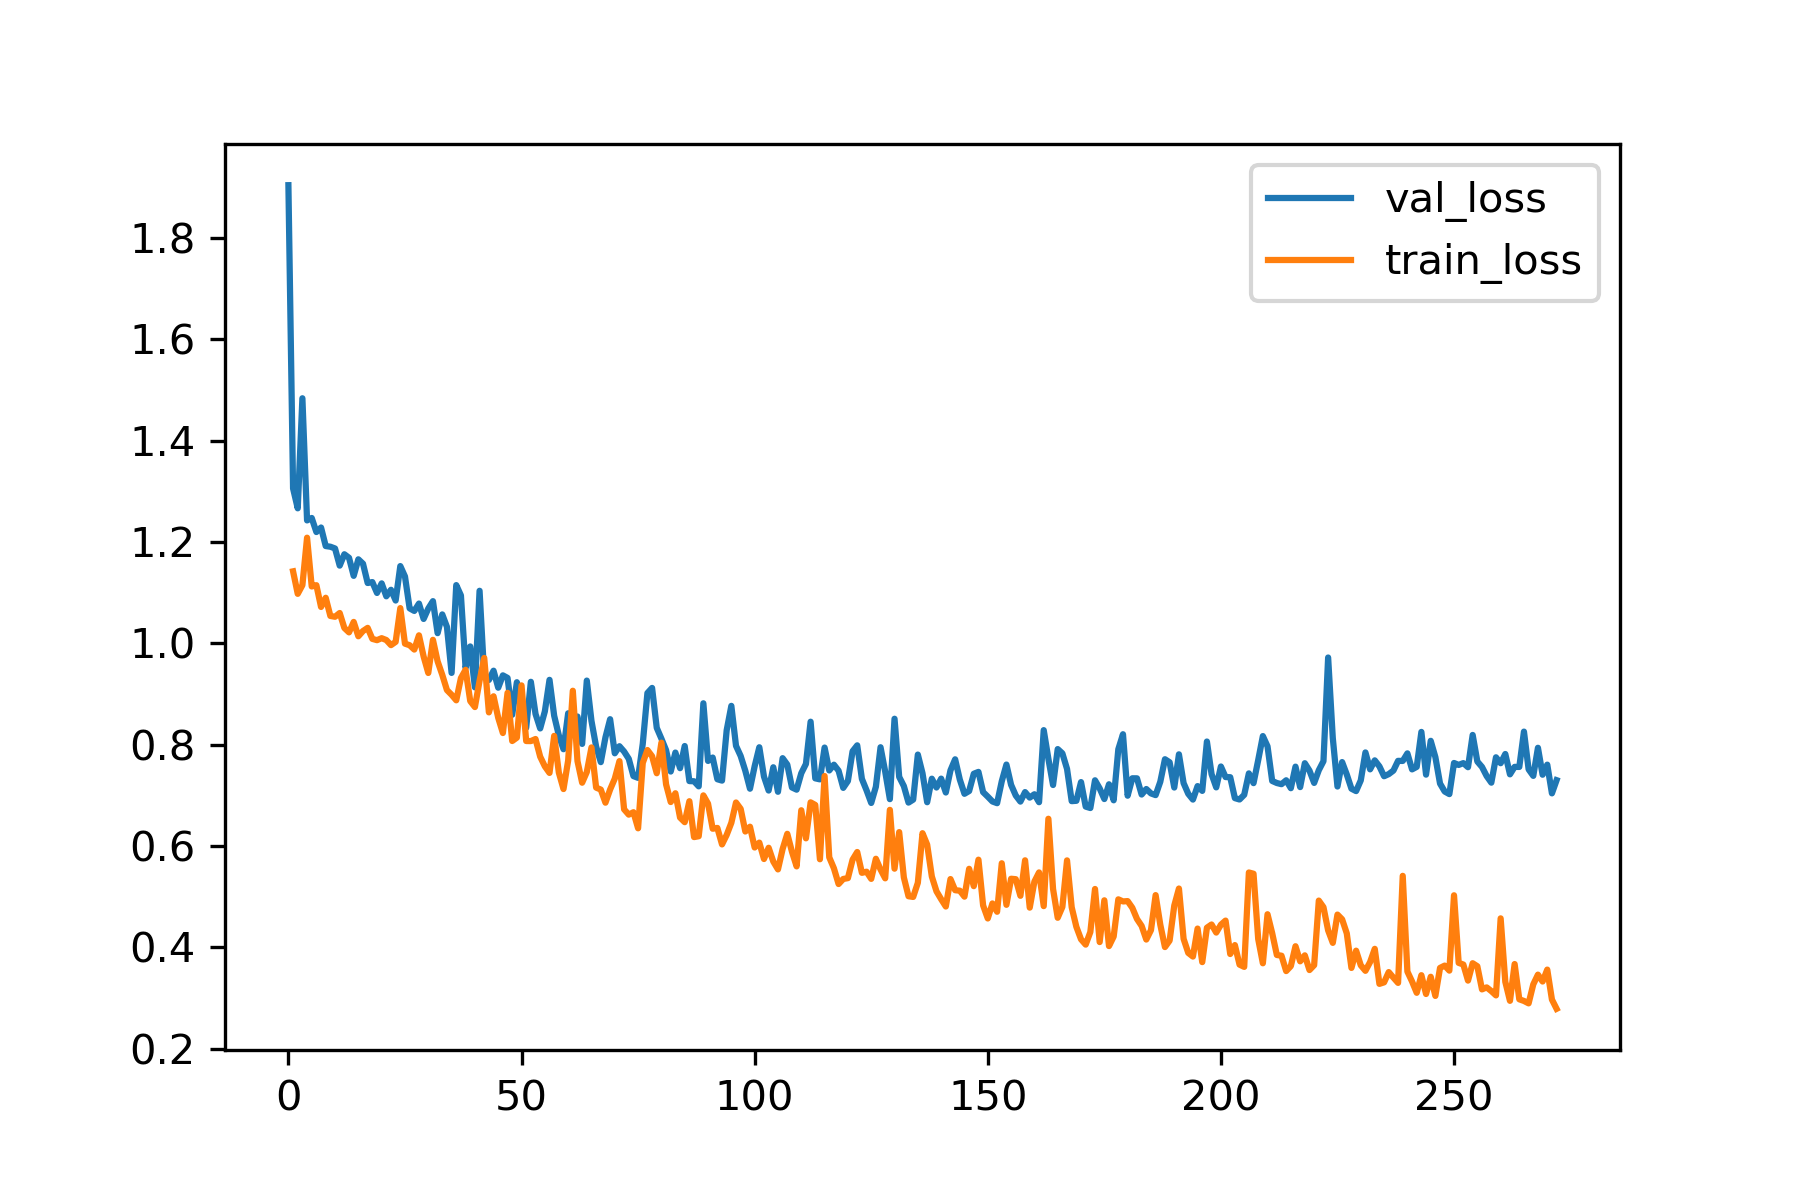

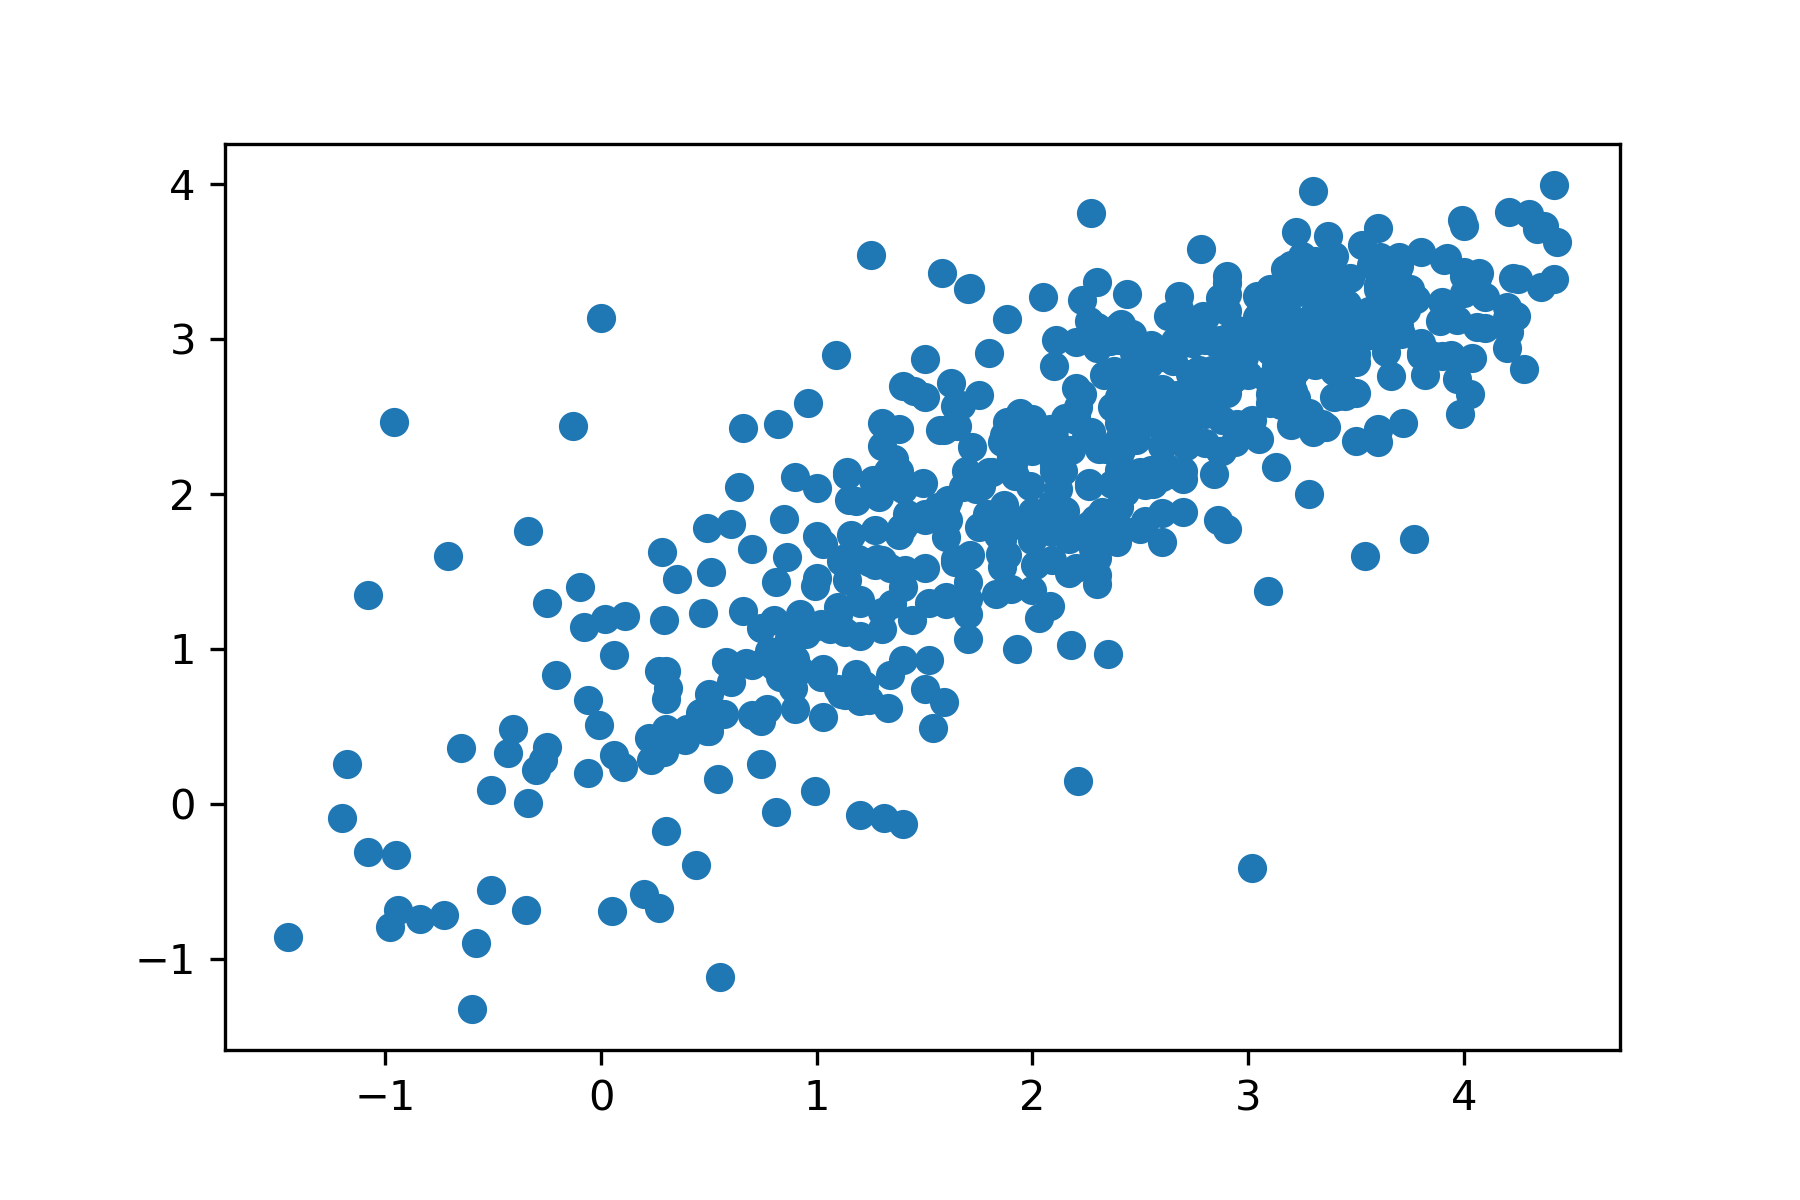

In [12]:
model_LipopModel1,data_LipopModel1 = bg.default_model_run(
        "LipopModel1",
        model_LipopModel1,
        loader_LipopModel1,
                      force_run=False,
                      #force_test_data_reload=True,
                    #min_epochs=200,
                    early_stopping=True,
                    max_epochs=1000,
                    early_stopping_delta=0.0,
                   detect_lr=False,
                    early_stop_patience=100,
    )

In [14]:
import numpy as np
#list(model_FGModel1.parameters())
model_parameters = filter(lambda p: p.requires_grad, model_LipopModel1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

2211468

In [15]:
true=[]
pred=[]
try:
    loader_LipopModel1.train_dataloader()
except:
    loader_LipopModel1.setup()
    
for l in [
        loader_LipopModel1.train_dataloader(),
          loader_LipopModel1.val_dataloader(),
          loader_LipopModel1.test_dataloader()
         ]:
    for d in l:
        pred.extend(model_LipopModel1(d).detach().flatten().numpy().tolist())
        true.extend(d.y_graph_features.flatten().numpy().tolist())
        
    #print(()-np.exp(d.y.numpy())).mean())

pred=np.array(pred)
true=np.array(true)


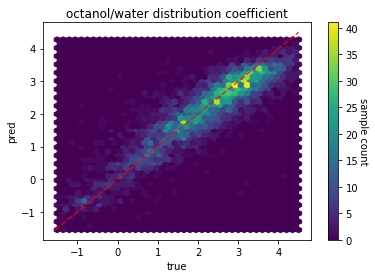

In [25]:
import matplotlib.pyplot as plt

dmin=min(true.min(),pred.min())
dmax=max(true.max(),pred.max())

plt.hexbin(true,pred,gridsize=40)
plt.plot([dmin,dmax],[dmin,dmax],"--r",alpha=0.75)
#plt.plot(true,pred,"o",alpha=0.3,markeredgecolor="w")
plt.xlabel("true")
plt.ylabel("pred")
plt.title("octanol/water distribution coefficient")
clb = plt.colorbar() 
clb.set_label('sample count', rotation=270,labelpad=10)
plt.show()
plt.close()
#plt.plot(np.exp(pred),np.exp(true),"o")
#plt.show()
#plt.close()

In [19]:
#print(np.abs(np.exp(pred)-np.exp(true)).mean())
import datetime
np.sqrt((np.abs(pred-true)**2).mean()),np.abs(pred-true).mean(),datetime.datetime.now()

(0.539874189194995,
 0.4032038376081203,
 datetime.datetime(2021, 6, 15, 13, 37, 4, 156362))

ChemGCModel(
  (chem_layer): Sequential(
    (0): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=38, out_features=41, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=41, out_features=41, bias=True)
        (3): ELU(alpha=1.0)
      )
      (gc): GCNConv(79, 59)
      (combine): Sequential(
        (0): Linear(in_features=100, out_features=23, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (1): ChemGCLayer(
      (fcnn): Sequential(
        (0): Linear(in_features=61, out_features=41, bias=True)
        (1): Dropout(p=0.12399616850697015, inplace=False)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=41, out_features=41, bias=True)
        (4): Dropout(p=0.12399616850697015, inplace=False)
        (5): ELU(alpha=1.0)
      )
      (gc): GCNConv(102, 59)
      (combine): Sequential(
        (0): Linear(in_features=100, out_features=23, bias=True)
        (1): Dropout(p=0.12399616850697015, inplace=False)
        (2): EL

In [ ]:
import numpy as np
ysa=np.array(ys)

In [ ]:
import optuna
study = optuna.create_study(study_name="aaa",
                            direction="minimize",
                           )